# Task 3: Customer Segmentation / Clustering

# DBSCAN

Davies-Bouldin Index (DBI): 0.896853010306143
Silhouette Score: 0.28576403833738145
Calinski-Harabasz Index: 16.314416649605196
Dunn Index: 0.4988276009929033


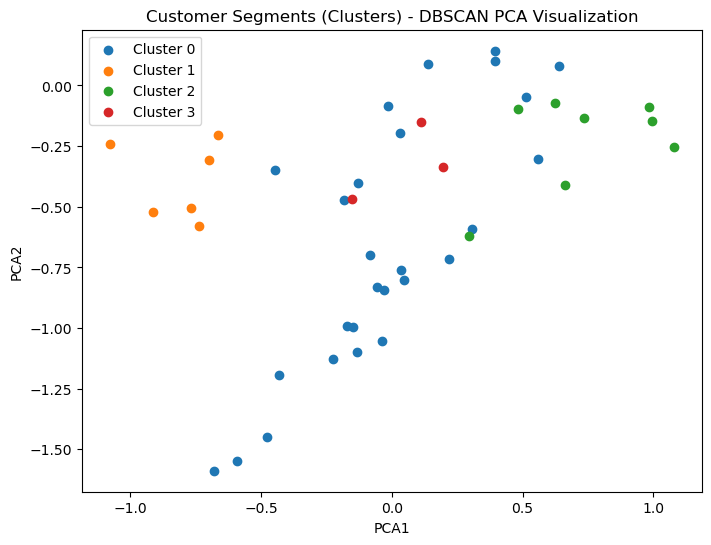

In [32]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

# Load customer and transaction data from CSV files
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Merge customer profile data with transaction details using CustomerID as the key
df = pd.merge(customers_df, transactions_df, on='CustomerID', how='inner')

# Feature Engineering: Aggregate data to create useful customer-level features
customer_summary = df.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean')
).reset_index()

# Calculate 'recency' - how many days since the last transaction
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
latest_transaction = df.groupby('CustomerID')['TransactionDate'].max().reset_index()
latest_transaction['recency'] = (pd.to_datetime('today') - latest_transaction['TransactionDate']).dt.days
customer_summary = pd.merge(customer_summary, latest_transaction[['CustomerID', 'recency']], on='CustomerID')

# Include Region from the customer profile to make the dataset richer
customer_summary = pd.merge(customer_summary, customers_df[['CustomerID', 'Region']], on='CustomerID')

# Select the features we want to use for clustering: spending, frequency, and recency
df_cluster = customer_summary[['total_spent', 'transaction_count', 'avg_transaction_value', 'recency']]

# One-hot encode the categorical feature 'Region' (use this if it's categorical data)
df_cluster = pd.get_dummies(df_cluster, drop_first=True)

# Standardize the data to ensure features have similar scales (important for distance-based algorithms like DBSCAN)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # eps and min_samples are hyperparameters
customer_summary['dbscan_cluster'] = dbscan.fit_predict(df_scaled)

# Remove noise points (label = -1)
valid_labels = customer_summary['dbscan_cluster'] != -1

# Calculate Davies-Bouldin Index (DBI) - Lower value means better clustering
db_index_dbscan = davies_bouldin_score(df_scaled[valid_labels], customer_summary['dbscan_cluster'][valid_labels])

# Calculate Silhouette Score - The higher, the better (range: -1 to 1)
silhouette_dbscan = silhouette_score(df_scaled[valid_labels], customer_summary['dbscan_cluster'][valid_labels])

# Calculate Calinski-Harabasz Index - Higher values indicate better clustering (variance ratio)
calinski_harabasz_dbscan = calinski_harabasz_score(df_scaled[valid_labels], customer_summary['dbscan_cluster'][valid_labels])

# Dunn Index - Higher values mean better clustering (measures compactness and separation)
def dunn_index(X, labels):
    clusters = np.unique(labels)
    inter_distances = []
    intra_distances = []
    for i in clusters:
        cluster_points = X[labels == i]
        other_points = X[labels != i]
        
        # Intra-cluster distance (average distance within a cluster)
        intra_distances.append(np.mean(pairwise_distances(cluster_points)))
        
        # Inter-cluster distance (minimum distance between clusters)
        min_dist = np.min(pairwise_distances(cluster_points, other_points))
        inter_distances.append(min_dist)
    
    return np.min(inter_distances) / np.max(intra_distances)

dunn_dbscan = dunn_index(df_scaled[valid_labels], customer_summary['dbscan_cluster'][valid_labels])

# Print all the clustering evaluation metrics
print(f'Davies-Bouldin Index (DBI): {db_index_dbscan}')
print(f'Silhouette Score: {silhouette_dbscan}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_dbscan}')
print(f'Dunn Index: {dunn_dbscan}')

# Apply PCA to reduce the data to 2D for visualization (important for visualizing high-dimensional data)
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Create a DataFrame with PCA components and their respective cluster labels
df_pca_df = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])
df_pca_df['dbscan_cluster'] = customer_summary['dbscan_cluster']

# Plot the clusters in the 2D PCA space (Each cluster will be shown with a different color)
plt.figure(figsize=(8, 6))
for cluster in np.unique(customer_summary['dbscan_cluster']):
    if cluster != -1:  # Skip the noise points (label = -1)
        plt.scatter(df_pca_df[df_pca_df['dbscan_cluster'] == cluster]['PCA1'],
                    df_pca_df[df_pca_df['dbscan_cluster'] == cluster]['PCA2'],
                    label=f'Cluster {cluster}')

# Customize the plot
plt.title('Customer Segments (Clusters) - DBSCAN PCA Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

# Save the customer ID along with the assigned cluster label to a CSV file for further analysis
customer_summary[['CustomerID', 'dbscan_cluster']].to_csv('dbscan_customer_segments.csv', index=False)


# AgglomerativeClustering

In [29]:
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Clustering
agg_clust = AgglomerativeClustering(n_clusters=n_clusters)
customer_summary['agg_cluster'] = agg_clust.fit_predict(df_scaled)

# Evaluate Agglomerative Clustering with the same metrics
db_index_agg = davies_bouldin_score(df_scaled, customer_summary['agg_cluster'])
silhouette_agg = silhouette_score(df_scaled, customer_summary['agg_cluster'])
calinski_harabasz_agg = calinski_harabasz_score(df_scaled, customer_summary['agg_cluster'])
dunn_agg = dunn_index(df_scaled, customer_summary['agg_cluster'])

# Print the results
print(f'Agglomerative Clustering - Davies-Bouldin Index (DBI): {db_index_agg}')
print(f'Agglomerative Clustering - Silhouette Score: {silhouette_agg}')
print(f'Agglomerative Clustering - Calinski-Harabasz Index: {calinski_harabasz_agg}')
print(f'Agglomerative Clustering - Dunn Index: {dunn_agg}')


Agglomerative Clustering - Davies-Bouldin Index (DBI): 1.071825275805084
Agglomerative Clustering - Silhouette Score: 0.31029538870131274
Agglomerative Clustering - Calinski-Harabasz Index: 86.52526031685213
Agglomerative Clustering - Dunn Index: 0.18418655936290143


# GaussianMixture

In [30]:
from sklearn.mixture import GaussianMixture

# Try Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
customer_summary['gmm_cluster'] = gmm.fit_predict(df_scaled)

# Evaluate GMM clustering with the same metrics
db_index_gmm = davies_bouldin_score(df_scaled, customer_summary['gmm_cluster'])
silhouette_gmm = silhouette_score(df_scaled, customer_summary['gmm_cluster'])
calinski_harabasz_gmm = calinski_harabasz_score(df_scaled, customer_summary['gmm_cluster'])
inertia_gmm = np.sum(gmm.covariances_)
dunn_gmm = dunn_index(df_scaled, customer_summary['gmm_cluster'])

# Print the results
print(f'Gaussian Mixture Model - Davies-Bouldin Index (DBI): {db_index_gmm}')
print(f'Gaussian Mixture Model - Silhouette Score: {silhouette_gmm}')
print(f'Gaussian Mixture Model - Calinski-Harabasz Index: {calinski_harabasz_gmm}')
print(f'Gaussian Mixture Model - Inertia: {inertia_gmm}')
print(f'Gaussian Mixture Model - Dunn Index: {dunn_gmm}')


Gaussian Mixture Model - Davies-Bouldin Index (DBI): 1.2998283952485812
Gaussian Mixture Model - Silhouette Score: 0.2509478115213887
Gaussian Mixture Model - Calinski-Harabasz Index: 67.88569643578113
Gaussian Mixture Model - Inertia: 11.569946612600445
Gaussian Mixture Model - Dunn Index: 0.07578805950441153


C:\Users\diwak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


# K-Means

C:\Users\diwak\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


K-Means - Davies-Bouldin Index (DBI): 1.0913247914357176
K-Means - Silhouette Score: 0.27331221254351595
K-Means - Calinski-Harabasz Index: 96.54459853814015
K-Means - Dunn Index: 0.059467334093063505


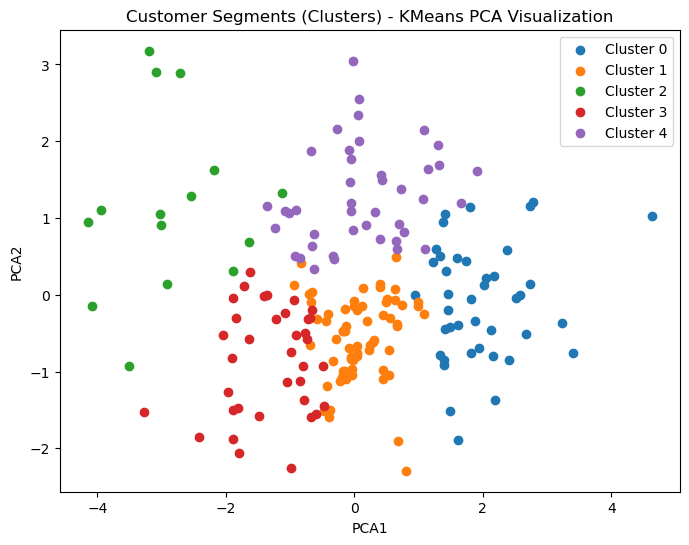

In [36]:

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Change the number of clusters as needed
customer_summary['kmeans_cluster'] = kmeans.fit_predict(df_scaled)

# Calculate Davies-Bouldin Index (DBI) - Lower value means better clustering
db_index_kmeans = davies_bouldin_score(df_scaled, customer_summary['kmeans_cluster'])

# Calculate Silhouette Score - The higher, the better (range: -1 to 1)
silhouette_kmeans = silhouette_score(df_scaled, customer_summary['kmeans_cluster'])

# Calculate Calinski-Harabasz Index - Higher values indicate better clustering (variance ratio)
calinski_harabasz_kmeans = calinski_harabasz_score(df_scaled, customer_summary['kmeans_cluster'])

# Dunn Index - Higher values mean better clustering (measures compactness and separation)
dunn_kmeans = dunn_index(df_scaled, customer_summary['kmeans_cluster'])

# Print all the clustering evaluation metrics
print(f'K-Means - Davies-Bouldin Index (DBI): {db_index_kmeans}')
print(f'K-Means - Silhouette Score: {silhouette_kmeans}')
print(f'K-Means - Calinski-Harabasz Index: {calinski_harabasz_kmeans}')
print(f'K-Means - Dunn Index: {dunn_kmeans}')

# Apply PCA to reduce the data to 2D for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Create a DataFrame with PCA components and their respective cluster labels
df_pca_df = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])
df_pca_df['kmeans_cluster'] = customer_summary['kmeans_cluster']

# Plot the clusters in the 2D PCA space
plt.figure(figsize=(8, 6))
for cluster in range(5):  # Adjust this for your number of clusters
    plt.scatter(df_pca_df[df_pca_df['kmeans_cluster'] == cluster]['PCA1'],
                df_pca_df[df_pca_df['kmeans_cluster'] == cluster]['PCA2'],
                label=f'Cluster {cluster}')

# Customize the plot
plt.title('Customer Segments (Clusters) - KMeans PCA Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

# Save the customer ID along with the assigned cluster label to a CSV file
customer_summary[['CustomerID', 'kmeans_cluster']].to_csv('kmeans_customer_segments.csv', index=False)
